### Sci-kit Optimize for Hyperparameter Optimization

[Sci-kit Optimize](https://scikit-optimize.github.io/) , or skopt, is a simple and efficient library to minimize (very) expensive and noisy black-box functions. It implements several methods for sequential model-based optimization. skopt is reusable in many contexts and accessible.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

from keras import backend as K
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.callbacks import TensorBoard,EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations

C:\Users\nickj\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\nickj\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
skopt.__version__

'0.4'

### Hyper-Parameters to Optimize:
   * Learning Rate
   * Number of Fully-Connected Layers
   * Number of Neurons in each Layer
   * Activation Function in each Layer
   * Patience

#### Learning Rate Range

For the learning rate we will be using a logarithmic distribution from 1e-6 to 1e-2

In [3]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform')

#### Number of Dense Layers Range

We want to consider 1 to 5 neurons

In [4]:
dim_num_dense_layers = Integer(low=1, high=5)

#### Number of Dense Layers Range

In [5]:
dim_num_dense_nodes = Integer(low=5, high=512)

#### Activation Function Range

In [6]:
dim_activation = Categorical(categories=['relu', 'sigmoid'])

#### Patience

In [7]:
dim_patience = Integer(low=1, high=25)

#### List of Dimensions

In [8]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
             dim_patience]

#### Starting Point

This is the starting point of our search. The values that I have provided are neither good or bad but merely random

In [9]:
default_parameters = [1e-5, 1, 16, 'relu',2]

### Load Data

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [11]:
print("Training-set:\t\t{}".format(len(data.train.labels)))
print("Test-set:\t\t{}".format(len(data.test.labels)))
print("Validation-set:\t{}".format(len(data.validation.labels)))

Training-set:		55000
Test-set:		10000
Validation-set:	5000


### Convert One Hot Encoded Labels into Label Encode

In [12]:
data.test.cls = np.argmax(data.test.labels, axis=1)
validation_data = (data.validation.images, data.validation.labels)

### Constants

In [13]:
img_size = 28
img_size_flat = img_size * img_size
num_classes = 10

### Model

In [14]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation,patience):

    model = Sequential()
    model.add(InputLayer(input_shape=(img_size_flat,)))
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))
        
    optimizer = Adam(lr=learning_rate)
    
    

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [15]:
path_best_model = 'best_model.keras'

In [16]:
best_accuracy = 0.0

### Fitess

Function that will be fed onto the optimization algorithm

In [17]:
def fitness(dimensions):    
    learning_rate = dimensions[0]
    num_dense_layers = dimensions[1]
    num_dense_nodes = dimensions[2]
    activation = dimensions[3]
    patience = dimensions[4]
    
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print('patience:', patience)
    print()
    
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                        patience=patience)

   
    early_stop = EarlyStopping(monitor='val_acc', patience=patience, verbose=1)

    history = model.fit(x=data.train.images,
                        y=data.train.labels,
                        epochs=1000,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[early_stop])

    accuracy = history.history['val_acc'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:

        model.save(path_best_model)

        best_accuracy = accuracy

    del model

    K.clear_session()

    return -accuracy

In [18]:
%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', 
                            n_calls=100,
                            x0=default_parameters)

Wall time: 0 ns
learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu
patience: 2

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 3s 50us/step - loss: 2.2854 - acc: 0.1637 - val_loss: 2.2044 - val_acc: 0.2132
Epoch 2/1000
55000/55000 [==============================] - 1s 24us/step - loss: 2.1185 - acc: 0.2917 - val_loss: 2.0407 - val_acc: 0.3596
Epoch 3/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.9640 - acc: 0.4178 - val_loss: 1.8902 - val_acc: 0.4624
Epoch 4/1000
55000/55000 [==============================] - 1s 24us/step - loss: 1.8230 - acc: 0.4945 - val_loss: 1.7527 - val_acc: 0.5256
Epoch 5/1000
55000/55000 [==============================] - 1s 24us/step - loss: 1.6910 - acc: 0.5492 - val_loss: 1.6221 - val_acc: 0.5764
Epoch 6/1000
55000/55000 [==============================] - 1s 24us/step - loss: 1.5673 - acc: 0.5952 - val_loss: 1.5050 - val_acc: 0.6156
Epoch 7/

55000/55000 [==============================] - 1s 25us/step - loss: 1.0308 - acc: 0.8185 - val_loss: 1.0073 - val_acc: 0.8274
Epoch 53/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.0173 - acc: 0.8200 - val_loss: 0.9938 - val_acc: 0.8280
Epoch 54/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.0041 - acc: 0.8211 - val_loss: 0.9807 - val_acc: 0.8302
Epoch 55/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.9912 - acc: 0.8224 - val_loss: 0.9679 - val_acc: 0.8310
Epoch 56/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.9787 - acc: 0.8240 - val_loss: 0.9554 - val_acc: 0.8334
Epoch 57/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.9665 - acc: 0.8250 - val_loss: 0.9432 - val_acc: 0.8336
Epoch 58/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.9545 - acc: 0.8262 - val_loss: 0.9313 - val_acc: 0.8340
Epoch 59/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 25us/step - loss: 0.4566 - acc: 0.8880 - val_loss: 0.4343 - val_acc: 0.8952
Epoch 169/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4551 - acc: 0.8881 - val_loss: 0.4327 - val_acc: 0.8956
Epoch 170/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4535 - acc: 0.8885 - val_loss: 0.4312 - val_acc: 0.8956
Epoch 171/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4520 - acc: 0.8886 - val_loss: 0.4297 - val_acc: 0.8958
Epoch 172/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4505 - acc: 0.8888 - val_loss: 0.4282 - val_acc: 0.8960
Epoch 173/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4491 - acc: 0.8891 - val_loss: 0.4267 - val_acc: 0.8962
Epoch 174/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4476 - acc: 0.8892 - val_loss: 0.4253 - val_acc: 0.8964
Epoch 175/1000
55000/55000 [

55000/55000 [==============================] - 1s 25us/step - loss: 0.3528 - acc: 0.9051 - val_loss: 0.3320 - val_acc: 0.9126
Epoch 285/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3523 - acc: 0.9052 - val_loss: 0.3315 - val_acc: 0.9128
Epoch 286/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3517 - acc: 0.9052 - val_loss: 0.3310 - val_acc: 0.9134
Epoch 287/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.3512 - acc: 0.9053 - val_loss: 0.3305 - val_acc: 0.9134
Epoch 288/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.3507 - acc: 0.9055 - val_loss: 0.3300 - val_acc: 0.9136
Epoch 289/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.3502 - acc: 0.9055 - val_loss: 0.3295 - val_acc: 0.9136
Epoch 290/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3497 - acc: 0.9058 - val_loss: 0.3290 - val_acc: 0.9136
Epoch 291/1000
55000/55000 [

learning rate: 1.8e-03
num_dense_layers: 2
num_dense_nodes: 378
activation: relu
patience: 12

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.2216 - acc: 0.9341 - val_loss: 0.0972 - val_acc: 0.9704
Epoch 2/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0858 - acc: 0.9729 - val_loss: 0.0973 - val_acc: 0.9702
Epoch 3/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0574 - acc: 0.9815 - val_loss: 0.0805 - val_acc: 0.9762
Epoch 4/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0425 - acc: 0.9860 - val_loss: 0.0918 - val_acc: 0.9752
Epoch 5/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0328 - acc: 0.9893 - val_loss: 0.0828 - val_acc: 0.9796
Epoch 6/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0260 - acc: 0.9912 - val_loss: 0.0998 - val_acc: 0.9762
Epoch 7/1000
55000/550

Epoch 11/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0297 - acc: 0.9923 - val_loss: 0.0670 - val_acc: 0.9804
Epoch 12/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0253 - acc: 0.9937 - val_loss: 0.0660 - val_acc: 0.9806
Epoch 13/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0215 - acc: 0.9946 - val_loss: 0.0669 - val_acc: 0.9806
Epoch 14/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0176 - acc: 0.9962 - val_loss: 0.0636 - val_acc: 0.9822
Epoch 15/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0145 - acc: 0.9973 - val_loss: 0.0646 - val_acc: 0.9840
Epoch 16/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0127 - acc: 0.9975 - val_loss: 0.0676 - val_acc: 0.9810
Epoch 17/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0101 - acc: 0.9983 - val_loss: 0.0656 - val_acc: 0.9812
Epoch 18/1000
55000/

55000/55000 [==============================] - 2s 31us/step - loss: 0.1910 - acc: 0.9439 - val_loss: 0.1847 - val_acc: 0.9458
Epoch 71/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.1893 - acc: 0.9447 - val_loss: 0.1832 - val_acc: 0.9462
Epoch 72/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.1878 - acc: 0.9452 - val_loss: 0.1816 - val_acc: 0.9472
Epoch 73/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.1863 - acc: 0.9453 - val_loss: 0.1806 - val_acc: 0.9468
Epoch 74/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.1849 - acc: 0.9460 - val_loss: 0.1792 - val_acc: 0.9476
Epoch 75/1000
55000/55000 [==============================] - ETA: 0s - loss: 0.1832 - acc: 0.946 - 2s 32us/step - loss: 0.1833 - acc: 0.9461 - val_loss: 0.1782 - val_acc: 0.9478
Epoch 76/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.1819 - acc: 0.9472 - val_loss: 0.1766 - val_acc: 0.9

Epoch 16/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.3134 - acc: 0.9081 - val_loss: 0.2944 - val_acc: 0.9122
Epoch 17/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.3005 - acc: 0.9119 - val_loss: 0.2841 - val_acc: 0.9144
Epoch 18/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.2892 - acc: 0.9151 - val_loss: 0.2730 - val_acc: 0.9164
Epoch 19/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.2787 - acc: 0.9181 - val_loss: 0.2638 - val_acc: 0.9206
Epoch 20/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.2689 - acc: 0.9211 - val_loss: 0.2557 - val_acc: 0.9226
Epoch 21/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.2601 - acc: 0.9240 - val_loss: 0.2481 - val_acc: 0.9244
Epoch 22/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.2520 - acc: 0.9264 - val_loss: 0.2422 - val_acc: 0.9272
Epoch 23/1000
55000/

55000/55000 [==============================] - 2s 32us/step - loss: 0.0218 - acc: 0.9949 - val_loss: 0.0673 - val_acc: 0.9792
Epoch 66/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0205 - acc: 0.9955 - val_loss: 0.0668 - val_acc: 0.9798
Epoch 67/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0195 - acc: 0.9960 - val_loss: 0.0656 - val_acc: 0.9794
Epoch 68/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0187 - acc: 0.9961 - val_loss: 0.0658 - val_acc: 0.9798
Epoch 69/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0178 - acc: 0.9965 - val_loss: 0.0654 - val_acc: 0.9814
Epoch 70/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0169 - acc: 0.9969 - val_loss: 0.0665 - val_acc: 0.9808
Epoch 71/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0161 - acc: 0.9972 - val_loss: 0.0683 - val_acc: 0.9792
Epoch 72/1000
55000/55000 [=======

55000/55000 [==============================] - 3s 49us/step - loss: 0.0858 - acc: 0.9793 - val_loss: 0.1167 - val_acc: 0.9742
Epoch 25/1000
55000/55000 [==============================] - 3s 49us/step - loss: 0.0715 - acc: 0.9826 - val_loss: 0.1609 - val_acc: 0.9710
Epoch 26/1000
55000/55000 [==============================] - 3s 49us/step - loss: 0.1575 - acc: 0.9671 - val_loss: 0.5075 - val_acc: 0.9150
Epoch 27/1000
55000/55000 [==============================] - 3s 49us/step - loss: 0.4656 - acc: 0.9082 - val_loss: 0.6058 - val_acc: 0.9184
Epoch 28/1000
55000/55000 [==============================] - 3s 49us/step - loss: 0.2702 - acc: 0.9433 - val_loss: 0.2814 - val_acc: 0.9520
Epoch 29/1000
55000/55000 [==============================] - 3s 49us/step - loss: 0.3796 - acc: 0.9297 - val_loss: 0.6574 - val_acc: 0.9360
Epoch 30/1000
55000/55000 [==============================] - 3s 49us/step - loss: 0.3466 - acc: 0.9340 - val_loss: 0.3128 - val_acc: 0.9398
Epoch 31/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 41us/step - loss: 0.2065 - acc: 0.9423 - val_loss: 0.1984 - val_acc: 0.9452
Epoch 91/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.2053 - acc: 0.9429 - val_loss: 0.1974 - val_acc: 0.9456
Epoch 92/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.2041 - acc: 0.9431 - val_loss: 0.1964 - val_acc: 0.9462
Epoch 93/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.2030 - acc: 0.9433 - val_loss: 0.1952 - val_acc: 0.9462
Epoch 94/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.2018 - acc: 0.9437 - val_loss: 0.1942 - val_acc: 0.9464
Epoch 95/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.2007 - acc: 0.9443 - val_loss: 0.1930 - val_acc: 0.9462
Epoch 96/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.1995 - acc: 0.9445 - val_loss: 0.1920 - val_acc: 0.9470
Epoch 97/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 41us/step - loss: 0.1216 - acc: 0.9657 - val_loss: 0.1267 - val_acc: 0.9644
Epoch 207/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.1211 - acc: 0.9658 - val_loss: 0.1265 - val_acc: 0.9654
Epoch 208/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.1207 - acc: 0.9660 - val_loss: 0.1260 - val_acc: 0.9652
Epoch 209/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.1203 - acc: 0.9661 - val_loss: 0.1258 - val_acc: 0.9654
Epoch 210/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.1198 - acc: 0.9663 - val_loss: 0.1254 - val_acc: 0.9660
Epoch 211/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.1193 - acc: 0.9664 - val_loss: 0.1251 - val_acc: 0.9652
Epoch 212/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.1189 - acc: 0.9666 - val_loss: 0.1247 - val_acc: 0.9654
Epoch 213/1000
55000/55000 [

55000/55000 [==============================] - 2s 40us/step - loss: 0.0813 - acc: 0.9771 - val_loss: 0.0979 - val_acc: 0.9720
Epoch 323/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0811 - acc: 0.9774 - val_loss: 0.0975 - val_acc: 0.9722
Epoch 324/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0808 - acc: 0.9773 - val_loss: 0.0975 - val_acc: 0.9718
Epoch 325/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0805 - acc: 0.9776 - val_loss: 0.0973 - val_acc: 0.9714
Epoch 326/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0803 - acc: 0.9777 - val_loss: 0.0971 - val_acc: 0.9722
Epoch 327/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0800 - acc: 0.9779 - val_loss: 0.0969 - val_acc: 0.9722
Epoch 328/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0798 - acc: 0.9779 - val_loss: 0.0969 - val_acc: 0.9720
Epoch 329/1000
55000/55000 [

55000/55000 [==============================] - 2s 41us/step - loss: 0.0562 - acc: 0.9853 - val_loss: 0.0821 - val_acc: 0.9762
Epoch 439/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0560 - acc: 0.9852 - val_loss: 0.0820 - val_acc: 0.9760
Epoch 440/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0558 - acc: 0.9853 - val_loss: 0.0818 - val_acc: 0.9760
Epoch 441/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0556 - acc: 0.9854 - val_loss: 0.0817 - val_acc: 0.9760
Epoch 442/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0555 - acc: 0.9853 - val_loss: 0.0819 - val_acc: 0.9760
Epoch 443/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0553 - acc: 0.9854 - val_loss: 0.0816 - val_acc: 0.9760
Epoch 444/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0551 - acc: 0.9854 - val_loss: 0.0814 - val_acc: 0.9760
Epoch 445/1000
55000/55000 [

Epoch 8/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0745 - acc: 0.9778 - val_loss: 0.1474 - val_acc: 0.9670
Epoch 9/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0718 - acc: 0.9794 - val_loss: 0.1680 - val_acc: 0.9604
Epoch 10/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0728 - acc: 0.9785 - val_loss: 0.1501 - val_acc: 0.9666
Epoch 11/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0674 - acc: 0.9804 - val_loss: 0.1601 - val_acc: 0.9672
Epoch 12/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0653 - acc: 0.9812 - val_loss: 0.1248 - val_acc: 0.9700
Epoch 13/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0557 - acc: 0.9837 - val_loss: 0.1477 - val_acc: 0.9714
Epoch 14/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0588 - acc: 0.9831 - val_loss: 0.1498 - val_acc: 0.9722
Epoch 15/1000
55000/55

Epoch 4/1000
55000/55000 [==============================] - 2s 42us/step - loss: 2.2911 - acc: 0.1740 - val_loss: 2.2888 - val_acc: 0.1130
Epoch 00004: early stopping

Accuracy: 11.30%

learning rate: 1.0e-06
num_dense_layers: 4
num_dense_nodes: 379
activation: relu
patience: 24

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.2820 - acc: 0.1552 - val_loss: 2.2514 - val_acc: 0.2394
Epoch 2/1000
55000/55000 [==============================] - 2s 42us/step - loss: 2.2181 - acc: 0.3121 - val_loss: 2.1836 - val_acc: 0.3848
Epoch 3/1000
55000/55000 [==============================] - 2s 42us/step - loss: 2.1452 - acc: 0.4573 - val_loss: 2.1021 - val_acc: 0.5116
Epoch 4/1000
55000/55000 [==============================] - 2s 42us/step - loss: 2.0553 - acc: 0.5596 - val_loss: 2.0009 - val_acc: 0.6018
Epoch 5/1000
55000/55000 [==============================] - 2s 42us/step - loss: 1.9445 - acc: 0.6350 - val_loss: 

55000/55000 [==============================] - 2s 42us/step - loss: 0.1868 - acc: 0.9469 - val_loss: 0.1805 - val_acc: 0.9510
Epoch 116/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1858 - acc: 0.9471 - val_loss: 0.1797 - val_acc: 0.9514
Epoch 117/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1849 - acc: 0.9473 - val_loss: 0.1788 - val_acc: 0.9510
Epoch 118/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1839 - acc: 0.9476 - val_loss: 0.1781 - val_acc: 0.9510
Epoch 119/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1829 - acc: 0.9481 - val_loss: 0.1772 - val_acc: 0.9522
Epoch 120/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1821 - acc: 0.9481 - val_loss: 0.1764 - val_acc: 0.9520
Epoch 121/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1812 - acc: 0.9486 - val_loss: 0.1756 - val_acc: 0.9522
Epoch 122/1000
55000/55000 [

55000/55000 [==============================] - 2s 42us/step - loss: 0.1145 - acc: 0.9675 - val_loss: 0.1219 - val_acc: 0.9678
Epoch 232/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1140 - acc: 0.9676 - val_loss: 0.1216 - val_acc: 0.9678
Epoch 233/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1137 - acc: 0.9679 - val_loss: 0.1213 - val_acc: 0.9674
Epoch 234/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1133 - acc: 0.9680 - val_loss: 0.1212 - val_acc: 0.9676
Epoch 235/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.1128 - acc: 0.9683 - val_loss: 0.1205 - val_acc: 0.9672
Epoch 236/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1125 - acc: 0.9682 - val_loss: 0.1204 - val_acc: 0.9672
Epoch 237/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1120 - acc: 0.9683 - val_loss: 0.1201 - val_acc: 0.9680
Epoch 238/1000
55000/55000 [

Epoch 2/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.2939 - acc: 0.9200 - val_loss: 0.2455 - val_acc: 0.9364
Epoch 3/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.2365 - acc: 0.9345 - val_loss: 0.2046 - val_acc: 0.9458
Epoch 4/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.2014 - acc: 0.9445 - val_loss: 0.1790 - val_acc: 0.9520
Epoch 5/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.1759 - acc: 0.9513 - val_loss: 0.1588 - val_acc: 0.9570
Epoch 6/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.1557 - acc: 0.9570 - val_loss: 0.1451 - val_acc: 0.9602
Epoch 7/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1396 - acc: 0.9614 - val_loss: 0.1322 - val_acc: 0.9652
Epoch 8/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.1261 - acc: 0.9653 - val_loss: 0.1243 - val_acc: 0.9676
Epoch 9/1000
55000/55000 [=

55000/55000 [==============================] - 1s 27us/step - loss: 0.1520 - acc: 0.9574 - val_loss: 0.1526 - val_acc: 0.9586
Epoch 66/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1505 - acc: 0.9579 - val_loss: 0.1515 - val_acc: 0.9592
Epoch 67/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1491 - acc: 0.9581 - val_loss: 0.1500 - val_acc: 0.9588
Epoch 68/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1477 - acc: 0.9587 - val_loss: 0.1487 - val_acc: 0.9590
Epoch 69/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1463 - acc: 0.9590 - val_loss: 0.1477 - val_acc: 0.9598
Epoch 70/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1449 - acc: 0.9596 - val_loss: 0.1466 - val_acc: 0.9600
Epoch 71/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1436 - acc: 0.9599 - val_loss: 0.1455 - val_acc: 0.9602
Epoch 72/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 26us/step - loss: 0.0638 - acc: 0.9836 - val_loss: 0.0861 - val_acc: 0.9754
Epoch 182/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0634 - acc: 0.9837 - val_loss: 0.0858 - val_acc: 0.9754
Epoch 183/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0630 - acc: 0.9838 - val_loss: 0.0856 - val_acc: 0.9758
Epoch 184/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0626 - acc: 0.9840 - val_loss: 0.0855 - val_acc: 0.9758
Epoch 185/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0623 - acc: 0.9839 - val_loss: 0.0852 - val_acc: 0.9756
Epoch 186/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0619 - acc: 0.9842 - val_loss: 0.0850 - val_acc: 0.9764
Epoch 187/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0615 - acc: 0.9841 - val_loss: 0.0846 - val_acc: 0.9756
Epoch 188/1000
55000/55000 [

Epoch 11/1000
55000/55000 [==============================] - 2s 28us/step - loss: 2.4119 - acc: 0.0995 - val_loss: 2.4126 - val_acc: 0.0976
Epoch 12/1000
55000/55000 [==============================] - 2s 28us/step - loss: 2.4104 - acc: 0.0995 - val_loss: 2.4111 - val_acc: 0.0976
Epoch 13/1000
55000/55000 [==============================] - 2s 28us/step - loss: 2.4090 - acc: 0.0995 - val_loss: 2.4096 - val_acc: 0.0976
Epoch 14/1000
55000/55000 [==============================] - 1s 27us/step - loss: 2.4075 - acc: 0.0995 - val_loss: 2.4081 - val_acc: 0.0976
Epoch 15/1000
55000/55000 [==============================] - 1s 27us/step - loss: 2.4060 - acc: 0.0995 - val_loss: 2.4067 - val_acc: 0.0976
Epoch 16/1000
55000/55000 [==============================] - 1s 27us/step - loss: 2.4046 - acc: 0.0995 - val_loss: 2.4053 - val_acc: 0.0976
Epoch 17/1000
55000/55000 [==============================] - 2s 28us/step - loss: 2.4032 - acc: 0.0995 - val_loss: 2.4039 - val_acc: 0.0976
Epoch 18/1000
55000/

55000/55000 [==============================] - 2s 29us/step - loss: 0.1106 - acc: 0.9691 - val_loss: 0.1196 - val_acc: 0.9670
Epoch 101/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1094 - acc: 0.9697 - val_loss: 0.1192 - val_acc: 0.9674
Epoch 102/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.1084 - acc: 0.9699 - val_loss: 0.1181 - val_acc: 0.9682
Epoch 103/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1073 - acc: 0.9700 - val_loss: 0.1175 - val_acc: 0.9686
Epoch 104/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.1063 - acc: 0.9707 - val_loss: 0.1165 - val_acc: 0.9668
Epoch 105/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1053 - acc: 0.9709 - val_loss: 0.1158 - val_acc: 0.9680
Epoch 106/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.1043 - acc: 0.9711 - val_loss: 0.1153 - val_acc: 0.9682
Epoch 107/1000
55000/55000 [

55000/55000 [==============================] - 2s 28us/step - loss: 2.1021 - acc: 0.3449 - val_loss: 2.0784 - val_acc: 0.3702
Epoch 8/1000
55000/55000 [==============================] - 1s 27us/step - loss: 2.0648 - acc: 0.3937 - val_loss: 2.0401 - val_acc: 0.4154
Epoch 9/1000
55000/55000 [==============================] - 2s 28us/step - loss: 2.0265 - acc: 0.4404 - val_loss: 2.0007 - val_acc: 0.4566
Epoch 10/1000
55000/55000 [==============================] - 2s 28us/step - loss: 1.9870 - acc: 0.4851 - val_loss: 1.9602 - val_acc: 0.4996
Epoch 11/1000
55000/55000 [==============================] - 2s 28us/step - loss: 1.9464 - acc: 0.5246 - val_loss: 1.9186 - val_acc: 0.5404
Epoch 12/1000
55000/55000 [==============================] - 2s 28us/step - loss: 1.9047 - acc: 0.5601 - val_loss: 1.8759 - val_acc: 0.5712
Epoch 13/1000
55000/55000 [==============================] - 2s 28us/step - loss: 1.8620 - acc: 0.5918 - val_loss: 1.8323 - val_acc: 0.6012
Epoch 14/1000
55000/55000 [=========

55000/55000 [==============================] - 2s 27us/step - loss: 0.1239 - acc: 0.9662 - val_loss: 0.1286 - val_acc: 0.9666
Epoch 62/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.1224 - acc: 0.9666 - val_loss: 0.1277 - val_acc: 0.9670
Epoch 63/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1209 - acc: 0.9671 - val_loss: 0.1264 - val_acc: 0.9678
Epoch 64/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.1194 - acc: 0.9675 - val_loss: 0.1256 - val_acc: 0.9666
Epoch 65/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1181 - acc: 0.9680 - val_loss: 0.1243 - val_acc: 0.9676
Epoch 66/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1167 - acc: 0.9686 - val_loss: 0.1235 - val_acc: 0.9676
Epoch 67/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1153 - acc: 0.9691 - val_loss: 0.1227 - val_acc: 0.9682
Epoch 68/1000
55000/55000 [=======

Epoch 177/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0412 - acc: 0.9905 - val_loss: 0.0728 - val_acc: 0.9794
Epoch 178/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.0410 - acc: 0.9905 - val_loss: 0.0725 - val_acc: 0.9796
Epoch 179/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0406 - acc: 0.9907 - val_loss: 0.0723 - val_acc: 0.9798
Epoch 180/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0402 - acc: 0.9906 - val_loss: 0.0724 - val_acc: 0.9792
Epoch 181/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0399 - acc: 0.9907 - val_loss: 0.0723 - val_acc: 0.9800
Epoch 182/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0396 - acc: 0.9907 - val_loss: 0.0718 - val_acc: 0.9792
Epoch 183/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0393 - acc: 0.9909 - val_loss: 0.0717 - val_acc: 0.9804
Epoch 184/100

55000/55000 [==============================] - 2s 28us/step - loss: 0.0257 - acc: 0.9954 - val_loss: 0.0656 - val_acc: 0.9810
Epoch 236/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0255 - acc: 0.9953 - val_loss: 0.0659 - val_acc: 0.9802
Epoch 237/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.0253 - acc: 0.9954 - val_loss: 0.0658 - val_acc: 0.9804
Epoch 238/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0251 - acc: 0.9955 - val_loss: 0.0655 - val_acc: 0.9812
Epoch 239/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0249 - acc: 0.9956 - val_loss: 0.0653 - val_acc: 0.9806
Epoch 240/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.0247 - acc: 0.9955 - val_loss: 0.0652 - val_acc: 0.9812
Epoch 241/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.0245 - acc: 0.9958 - val_loss: 0.0653 - val_acc: 0.9804
Epoch 242/1000
55000/55000 [

55000/55000 [==============================] - 2s 40us/step - loss: 0.0681 - acc: 0.9796 - val_loss: 0.0895 - val_acc: 0.9740
Epoch 39/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0653 - acc: 0.9806 - val_loss: 0.0923 - val_acc: 0.9726
Epoch 40/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0625 - acc: 0.9818 - val_loss: 0.0861 - val_acc: 0.9744
Epoch 41/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0608 - acc: 0.9817 - val_loss: 0.0852 - val_acc: 0.9744
Epoch 42/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0579 - acc: 0.9827 - val_loss: 0.0865 - val_acc: 0.9754
Epoch 43/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0560 - acc: 0.9835 - val_loss: 0.0882 - val_acc: 0.9738
Epoch 44/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0537 - acc: 0.9847 - val_loss: 0.0864 - val_acc: 0.9742
Epoch 00044: early stopping

Accur

55000/55000 [==============================] - 2s 41us/step - loss: 0.0761 - acc: 0.9776 - val_loss: 0.0974 - val_acc: 0.9712
Epoch 110/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0753 - acc: 0.9779 - val_loss: 0.0966 - val_acc: 0.9726
Epoch 111/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0743 - acc: 0.9784 - val_loss: 0.0966 - val_acc: 0.9714
Epoch 112/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0735 - acc: 0.9791 - val_loss: 0.0962 - val_acc: 0.9724
Epoch 113/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0725 - acc: 0.9789 - val_loss: 0.0944 - val_acc: 0.9738
Epoch 114/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0716 - acc: 0.9791 - val_loss: 0.0941 - val_acc: 0.9734
Epoch 115/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0706 - acc: 0.9796 - val_loss: 0.0939 - val_acc: 0.9730
Epoch 116/1000
55000/55000 [

55000/55000 [==============================] - 2s 41us/step - loss: 0.0133 - acc: 0.9975 - val_loss: 0.0785 - val_acc: 0.9796
Epoch 226/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0133 - acc: 0.9974 - val_loss: 0.0771 - val_acc: 0.9808
Epoch 227/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0128 - acc: 0.9977 - val_loss: 0.0815 - val_acc: 0.9776
Epoch 228/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0126 - acc: 0.9977 - val_loss: 0.0806 - val_acc: 0.9804
Epoch 229/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0123 - acc: 0.9978 - val_loss: 0.0801 - val_acc: 0.9784
Epoch 230/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0121 - acc: 0.9979 - val_loss: 0.0777 - val_acc: 0.9798
Epoch 231/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0117 - acc: 0.9979 - val_loss: 0.0794 - val_acc: 0.9788
Epoch 232/1000
55000/55000 [

55000/55000 [==============================] - 2s 37us/step - loss: 0.0810 - acc: 0.9784 - val_loss: 0.1546 - val_acc: 0.9602
Epoch 23/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0776 - acc: 0.9793 - val_loss: 0.1481 - val_acc: 0.9596
Epoch 24/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0723 - acc: 0.9809 - val_loss: 0.1509 - val_acc: 0.9606
Epoch 25/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0685 - acc: 0.9821 - val_loss: 0.1463 - val_acc: 0.9622
Epoch 26/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0649 - acc: 0.9832 - val_loss: 0.1503 - val_acc: 0.9632
Epoch 27/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0607 - acc: 0.9843 - val_loss: 0.1488 - val_acc: 0.9624
Epoch 28/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0575 - acc: 0.9856 - val_loss: 0.1559 - val_acc: 0.9596
Epoch 29/1000
55000/55000 [=======

55000/55000 [==============================] - 3s 48us/step - loss: 0.0649 - acc: 0.9817 - val_loss: 0.0951 - val_acc: 0.9706
Epoch 25/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.0623 - acc: 0.9828 - val_loss: 0.0854 - val_acc: 0.9742
Epoch 26/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.0588 - acc: 0.9839 - val_loss: 0.0858 - val_acc: 0.9748
Epoch 27/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.0561 - acc: 0.9844 - val_loss: 0.0846 - val_acc: 0.9750
Epoch 28/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.0533 - acc: 0.9854 - val_loss: 0.0809 - val_acc: 0.9756
Epoch 29/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.0508 - acc: 0.9859 - val_loss: 0.0842 - val_acc: 0.9758
Epoch 30/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.0483 - acc: 0.9869 - val_loss: 0.0809 - val_acc: 0.9772
Epoch 31/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 25us/step - loss: 1.2897 - acc: 0.7953 - val_loss: 1.2641 - val_acc: 0.7966
Epoch 31/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.2666 - acc: 0.7980 - val_loss: 1.2412 - val_acc: 0.7982
Epoch 32/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.2443 - acc: 0.8003 - val_loss: 1.2189 - val_acc: 0.8014
Epoch 33/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.2226 - acc: 0.8027 - val_loss: 1.1973 - val_acc: 0.8034
Epoch 34/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.2015 - acc: 0.8047 - val_loss: 1.1764 - val_acc: 0.8052
Epoch 35/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.1811 - acc: 0.8068 - val_loss: 1.1561 - val_acc: 0.8078
Epoch 36/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.1614 - acc: 0.8085 - val_loss: 1.1365 - val_acc: 0.8100
Epoch 37/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 36us/step - loss: 0.0826 - acc: 0.9754 - val_loss: 0.0899 - val_acc: 0.9738
Epoch 8/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0689 - acc: 0.9790 - val_loss: 0.0920 - val_acc: 0.9740
Epoch 9/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0599 - acc: 0.9813 - val_loss: 0.0850 - val_acc: 0.9754
Epoch 10/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0509 - acc: 0.9841 - val_loss: 0.0821 - val_acc: 0.9760
Epoch 11/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0419 - acc: 0.9869 - val_loss: 0.0780 - val_acc: 0.9764
Epoch 12/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0336 - acc: 0.9892 - val_loss: 0.0753 - val_acc: 0.9780
Epoch 13/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0296 - acc: 0.9914 - val_loss: 0.0769 - val_acc: 0.9760
Epoch 00013: early stopping

Accurac

55000/55000 [==============================] - 2s 31us/step - loss: 2.2403 - acc: 0.1626 - val_loss: 2.1378 - val_acc: 0.2684
Epoch 2/1000
55000/55000 [==============================] - 1s 26us/step - loss: 2.0738 - acc: 0.3209 - val_loss: 2.0111 - val_acc: 0.3718
Epoch 3/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.9703 - acc: 0.4027 - val_loss: 1.9231 - val_acc: 0.4280
Epoch 4/1000
55000/55000 [==============================] - 1s 24us/step - loss: 1.8933 - acc: 0.4434 - val_loss: 1.8527 - val_acc: 0.4588
Epoch 5/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.8294 - acc: 0.4721 - val_loss: 1.7920 - val_acc: 0.4922
Epoch 6/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.7733 - acc: 0.5066 - val_loss: 1.7377 - val_acc: 0.5338
Epoch 7/1000
55000/55000 [==============================] - 1s 24us/step - loss: 1.7225 - acc: 0.5521 - val_loss: 1.6880 - val_acc: 0.5868
Epoch 8/1000
55000/55000 [==============

55000/55000 [==============================] - 1s 24us/step - loss: 0.5432 - acc: 0.8489 - val_loss: 0.5378 - val_acc: 0.8550
Epoch 118/1000
55000/55000 [==============================] - 1s 23us/step - loss: 0.5415 - acc: 0.8495 - val_loss: 0.5363 - val_acc: 0.8554
Epoch 119/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.5398 - acc: 0.8499 - val_loss: 0.5349 - val_acc: 0.8560
Epoch 120/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.5381 - acc: 0.8504 - val_loss: 0.5333 - val_acc: 0.8554
Epoch 121/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.5364 - acc: 0.8510 - val_loss: 0.5322 - val_acc: 0.8560
Epoch 122/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.5349 - acc: 0.8517 - val_loss: 0.5307 - val_acc: 0.8566
Epoch 123/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.5333 - acc: 0.8522 - val_loss: 0.5293 - val_acc: 0.8562
Epoch 124/1000
55000/55000 [

55000/55000 [==============================] - 1s 25us/step - loss: 0.4487 - acc: 0.8741 - val_loss: 0.4657 - val_acc: 0.8728
Epoch 234/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4483 - acc: 0.8745 - val_loss: 0.4653 - val_acc: 0.8736
Epoch 235/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4478 - acc: 0.8748 - val_loss: 0.4651 - val_acc: 0.8744
Epoch 236/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4475 - acc: 0.8747 - val_loss: 0.4646 - val_acc: 0.8742
Epoch 237/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.4471 - acc: 0.8749 - val_loss: 0.4644 - val_acc: 0.8736
Epoch 238/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4467 - acc: 0.8753 - val_loss: 0.4641 - val_acc: 0.8740
Epoch 239/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.4463 - acc: 0.8751 - val_loss: 0.4644 - val_acc: 0.8728
Epoch 240/1000
55000/55000 [

55000/55000 [==============================] - 1s 24us/step - loss: 0.4147 - acc: 0.8847 - val_loss: 0.4407 - val_acc: 0.8762
Epoch 350/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.4145 - acc: 0.8847 - val_loss: 0.4405 - val_acc: 0.8784
Epoch 351/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.4143 - acc: 0.8847 - val_loss: 0.4408 - val_acc: 0.8774
Epoch 352/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4140 - acc: 0.8847 - val_loss: 0.4402 - val_acc: 0.8784
Epoch 353/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4138 - acc: 0.8849 - val_loss: 0.4407 - val_acc: 0.8780
Epoch 354/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4136 - acc: 0.8847 - val_loss: 0.4400 - val_acc: 0.8776
Epoch 355/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.4134 - acc: 0.8850 - val_loss: 0.4401 - val_acc: 0.8774
Epoch 356/1000
55000/55000 [

55000/55000 [==============================] - 1s 24us/step - loss: 0.3931 - acc: 0.8910 - val_loss: 0.4252 - val_acc: 0.8824
Epoch 466/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.3929 - acc: 0.8912 - val_loss: 0.4249 - val_acc: 0.8822
Epoch 467/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.3927 - acc: 0.8909 - val_loss: 0.4248 - val_acc: 0.8824
Epoch 468/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.3926 - acc: 0.8913 - val_loss: 0.4248 - val_acc: 0.8826
Epoch 469/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3924 - acc: 0.8912 - val_loss: 0.4245 - val_acc: 0.8824
Epoch 470/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3922 - acc: 0.8911 - val_loss: 0.4246 - val_acc: 0.8814
Epoch 471/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3921 - acc: 0.8913 - val_loss: 0.4243 - val_acc: 0.8822
Epoch 472/1000
55000/55000 [

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 2s 30us/step - loss: 1.1592 - acc: 0.7082 - val_loss: 0.7208 - val_acc: 0.8332
Epoch 2/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.6165 - acc: 0.8462 - val_loss: 0.5373 - val_acc: 0.8564
Epoch 3/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.5123 - acc: 0.8621 - val_loss: 0.4944 - val_acc: 0.8674
Epoch 4/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4686 - acc: 0.8703 - val_loss: 0.4456 - val_acc: 0.8792
Epoch 5/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4400 - acc: 0.8773 - val_loss: 0.4311 - val_acc: 0.8808
Epoch 6/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.4196 - acc: 0.8847 - val_loss: 0.4164 - val_acc: 0.8860
Epoch 7/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.4033 - acc: 0.8893 - val_loss: 0.4

55000/55000 [==============================] - 2s 41us/step - loss: 0.0042 - acc: 0.9986 - val_loss: 0.1498 - val_acc: 0.9732
Epoch 54/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0076 - acc: 0.9979 - val_loss: 0.2283 - val_acc: 0.9624
Epoch 55/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.1368 - val_acc: 0.9780
Epoch 56/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.1591 - val_acc: 0.9744
Epoch 57/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0076 - acc: 0.9978 - val_loss: 0.1367 - val_acc: 0.9782
Epoch 58/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.1379 - val_acc: 0.9778
Epoch 59/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.1550 - val_acc: 0.9738
Epoch 60/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 25us/step - loss: 0.0497 - acc: 0.9875 - val_loss: 0.0788 - val_acc: 0.9768
Epoch 83/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0488 - acc: 0.9879 - val_loss: 0.0783 - val_acc: 0.9778
Epoch 84/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0479 - acc: 0.9881 - val_loss: 0.0776 - val_acc: 0.9778
Epoch 85/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0470 - acc: 0.9883 - val_loss: 0.0772 - val_acc: 0.9772
Epoch 86/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0462 - acc: 0.9886 - val_loss: 0.0765 - val_acc: 0.9776
Epoch 87/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0453 - acc: 0.9887 - val_loss: 0.0768 - val_acc: 0.9776
Epoch 88/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0444 - acc: 0.9890 - val_loss: 0.0755 - val_acc: 0.9780
Epoch 89/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 35us/step - loss: 0.5858 - acc: 0.8061 - val_loss: 0.6186 - val_acc: 0.8036
Epoch 44/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.5796 - acc: 0.8084 - val_loss: 0.6243 - val_acc: 0.8044
Epoch 45/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5757 - acc: 0.8104 - val_loss: 0.6135 - val_acc: 0.8084
Epoch 46/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5712 - acc: 0.8125 - val_loss: 0.6164 - val_acc: 0.8088
Epoch 47/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5731 - acc: 0.8109 - val_loss: 0.6087 - val_acc: 0.8054
Epoch 48/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5661 - acc: 0.8144 - val_loss: 0.6095 - val_acc: 0.8072
Epoch 49/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5642 - acc: 0.8148 - val_loss: 0.6129 - val_acc: 0.8098
Epoch 50/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 36us/step - loss: 0.4689 - acc: 0.8783 - val_loss: 0.5597 - val_acc: 0.8652
Epoch 160/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4675 - acc: 0.8778 - val_loss: 0.5574 - val_acc: 0.8634
Epoch 161/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4663 - acc: 0.8785 - val_loss: 0.5595 - val_acc: 0.8646
Epoch 162/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4739 - acc: 0.8756 - val_loss: 0.5588 - val_acc: 0.8668
Epoch 163/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4647 - acc: 0.8791 - val_loss: 0.5571 - val_acc: 0.8636
Epoch 164/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4636 - acc: 0.8794 - val_loss: 0.5532 - val_acc: 0.8620
Epoch 165/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4659 - acc: 0.8792 - val_loss: 0.5595 - val_acc: 0.8656
Epoch 166/1000
55000/55000 [

55000/55000 [==============================] - 2s 36us/step - loss: 0.4481 - acc: 0.8839 - val_loss: 0.5558 - val_acc: 0.8692
Epoch 276/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4503 - acc: 0.8830 - val_loss: 0.5502 - val_acc: 0.8664
Epoch 277/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4483 - acc: 0.8827 - val_loss: 0.5496 - val_acc: 0.8678
Epoch 278/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4482 - acc: 0.8838 - val_loss: 0.5512 - val_acc: 0.8660
Epoch 279/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4487 - acc: 0.8827 - val_loss: 0.5527 - val_acc: 0.8650
Epoch 280/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4478 - acc: 0.8839 - val_loss: 0.5614 - val_acc: 0.8604
Epoch 00280: early stopping

Accuracy: 86.04%

learning rate: 5.5e-05
num_dense_layers: 3
num_dense_nodes: 512
activation: sigmoid
patience: 14

Train on 55000 samples, 

55000/55000 [==============================] - 2s 35us/step - loss: 0.0274 - acc: 0.9930 - val_loss: 0.0764 - val_acc: 0.9774
Epoch 111/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0265 - acc: 0.9932 - val_loss: 0.0752 - val_acc: 0.9776
Epoch 112/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0260 - acc: 0.9934 - val_loss: 0.0760 - val_acc: 0.9772
Epoch 113/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0253 - acc: 0.9935 - val_loss: 0.0770 - val_acc: 0.9776
Epoch 114/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0245 - acc: 0.9940 - val_loss: 0.0747 - val_acc: 0.9778
Epoch 115/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0240 - acc: 0.9940 - val_loss: 0.0754 - val_acc: 0.9776
Epoch 116/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0233 - acc: 0.9941 - val_loss: 0.0789 - val_acc: 0.9776
Epoch 117/1000
55000/55000 [

55000/55000 [==============================] - 2s 35us/step - loss: 0.0073 - acc: 0.9975 - val_loss: 0.0956 - val_acc: 0.9828
Epoch 26/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0066 - acc: 0.9977 - val_loss: 0.0989 - val_acc: 0.9816
Epoch 27/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0083 - acc: 0.9972 - val_loss: 0.1075 - val_acc: 0.9780
Epoch 28/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0070 - acc: 0.9975 - val_loss: 0.1067 - val_acc: 0.9816
Epoch 29/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0056 - acc: 0.9981 - val_loss: 0.0977 - val_acc: 0.9828
Epoch 30/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.0075 - acc: 0.9977 - val_loss: 0.1105 - val_acc: 0.9804
Epoch 00030: early stopping

Accuracy: 98.04%

learning rate: 3.7e-05
num_dense_layers: 5
num_dense_nodes: 5
activation: relu
patience: 25

Train on 55000 samples, validate o

55000/55000 [==============================] - 2s 36us/step - loss: 0.6405 - acc: 0.8025 - val_loss: 0.6383 - val_acc: 0.8064
Epoch 111/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.6378 - acc: 0.8036 - val_loss: 0.6368 - val_acc: 0.8060
Epoch 112/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.6354 - acc: 0.8045 - val_loss: 0.6332 - val_acc: 0.8090
Epoch 113/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.6330 - acc: 0.8055 - val_loss: 0.6322 - val_acc: 0.8078
Epoch 114/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.6306 - acc: 0.8062 - val_loss: 0.6287 - val_acc: 0.8090
Epoch 115/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.6284 - acc: 0.8076 - val_loss: 0.6274 - val_acc: 0.8096
Epoch 116/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.6261 - acc: 0.8081 - val_loss: 0.6253 - val_acc: 0.8116
Epoch 117/1000
55000/55000 [

55000/55000 [==============================] - 2s 36us/step - loss: 0.5101 - acc: 0.8516 - val_loss: 0.5157 - val_acc: 0.8558
Epoch 227/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5095 - acc: 0.8515 - val_loss: 0.5153 - val_acc: 0.8562
Epoch 228/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5087 - acc: 0.8521 - val_loss: 0.5143 - val_acc: 0.8566
Epoch 229/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5080 - acc: 0.8523 - val_loss: 0.5142 - val_acc: 0.8558
Epoch 230/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5073 - acc: 0.8524 - val_loss: 0.5131 - val_acc: 0.8566
Epoch 231/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5066 - acc: 0.8531 - val_loss: 0.5127 - val_acc: 0.8560
Epoch 232/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.5059 - acc: 0.8531 - val_loss: 0.5115 - val_acc: 0.8576
Epoch 233/1000
55000/55000 [

55000/55000 [==============================] - 2s 36us/step - loss: 0.4483 - acc: 0.8727 - val_loss: 0.4597 - val_acc: 0.8768
Epoch 343/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4478 - acc: 0.8731 - val_loss: 0.4597 - val_acc: 0.8768
Epoch 344/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4476 - acc: 0.8728 - val_loss: 0.4593 - val_acc: 0.8772
Epoch 345/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4472 - acc: 0.8729 - val_loss: 0.4587 - val_acc: 0.8782
Epoch 346/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4466 - acc: 0.8733 - val_loss: 0.4586 - val_acc: 0.8780
Epoch 347/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4462 - acc: 0.8736 - val_loss: 0.4584 - val_acc: 0.8774
Epoch 348/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.4458 - acc: 0.8735 - val_loss: 0.4578 - val_acc: 0.8788
Epoch 349/1000
55000/55000 [

Epoch 9/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.2159 - acc: 0.9389 - val_loss: 0.1974 - val_acc: 0.9454
Epoch 10/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.2039 - acc: 0.9421 - val_loss: 0.1882 - val_acc: 0.9484
Epoch 11/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1932 - acc: 0.9453 - val_loss: 0.1785 - val_acc: 0.9502
Epoch 12/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1836 - acc: 0.9478 - val_loss: 0.1715 - val_acc: 0.9538
Epoch 13/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1752 - acc: 0.9500 - val_loss: 0.1637 - val_acc: 0.9550
Epoch 14/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.1673 - acc: 0.9520 - val_loss: 0.1577 - val_acc: 0.9570
Epoch 15/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.1601 - acc: 0.9547 - val_loss: 0.1516 - val_acc: 0.9586
Epoch 16/1000
55000/5

55000/55000 [==============================] - 2s 40us/step - loss: 0.0041 - acc: 0.9997 - val_loss: 0.0749 - val_acc: 0.9814
Epoch 126/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 0.0764 - val_acc: 0.9806
Epoch 127/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0036 - acc: 0.9998 - val_loss: 0.0772 - val_acc: 0.9798
Epoch 00127: early stopping

Accuracy: 97.98%

learning rate: 7.1e-04
num_dense_layers: 2
num_dense_nodes: 512
activation: relu
patience: 6

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.2549 - acc: 0.9261 - val_loss: 0.1086 - val_acc: 0.9696
Epoch 2/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0893 - acc: 0.9729 - val_loss: 0.0840 - val_acc: 0.9750
Epoch 3/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0573 - acc: 0.9819 - val_loss: 0.0678 - v

55000/55000 [==============================] - 2s 30us/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.1227 - val_acc: 0.9784
Epoch 45/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.1197 - val_acc: 0.9780
Epoch 46/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0102 - acc: 0.9967 - val_loss: 0.1140 - val_acc: 0.9784
Epoch 47/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.1169 - val_acc: 0.9756
Epoch 48/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0030 - acc: 0.9993 - val_loss: 0.1051 - val_acc: 0.9782
Epoch 49/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1214 - val_acc: 0.9766
Epoch 50/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0022 - acc: 0.9995 - val_loss: 0.1232 - val_acc: 0.9764
Epoch 51/1000
55000/55000 [=======

Epoch 7/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.3017 - acc: 0.1119 - val_loss: 2.3010 - val_acc: 0.1126
Epoch 8/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.3020 - acc: 0.1108 - val_loss: 2.3016 - val_acc: 0.1126
Epoch 9/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.3019 - acc: 0.1114 - val_loss: 2.3012 - val_acc: 0.1126
Epoch 10/1000
55000/55000 [==============================] - 3s 50us/step - loss: 2.3019 - acc: 0.1123 - val_loss: 2.3008 - val_acc: 0.1126
Epoch 11/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.3020 - acc: 0.1117 - val_loss: 2.3013 - val_acc: 0.1126
Epoch 12/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.3019 - acc: 0.1104 - val_loss: 2.3022 - val_acc: 0.1126
Epoch 13/1000
55000/55000 [==============================] - 3s 49us/step - loss: 2.3020 - acc: 0.1120 - val_loss: 2.3022 - val_acc: 0.1126
Epoch 14/1000
55000/550

Epoch 33/1000
55000/55000 [==============================] - 3s 47us/step - loss: 0.1318 - acc: 0.9614 - val_loss: 0.1421 - val_acc: 0.9582
Epoch 34/1000
55000/55000 [==============================] - 3s 47us/step - loss: 0.1279 - acc: 0.9622 - val_loss: 0.1382 - val_acc: 0.9620
Epoch 35/1000
55000/55000 [==============================] - 3s 47us/step - loss: 0.1237 - acc: 0.9627 - val_loss: 0.1346 - val_acc: 0.9622
Epoch 36/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.1200 - acc: 0.9649 - val_loss: 0.1307 - val_acc: 0.9630
Epoch 37/1000
55000/55000 [==============================] - 3s 48us/step - loss: 0.1176 - acc: 0.9654 - val_loss: 0.1350 - val_acc: 0.9616
Epoch 38/1000
55000/55000 [==============================] - 3s 47us/step - loss: 0.1131 - acc: 0.9666 - val_loss: 0.1266 - val_acc: 0.9642
Epoch 39/1000
55000/55000 [==============================] - 3s 47us/step - loss: 0.1110 - acc: 0.9674 - val_loss: 0.1262 - val_acc: 0.9648
Epoch 40/1000
55000/

Epoch 2/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1134 - acc: 0.9651 - val_loss: 0.1376 - val_acc: 0.9618
Epoch 00002: early stopping

Accuracy: 96.18%

learning rate: 3.5e-04
num_dense_layers: 5
num_dense_nodes: 82
activation: relu
patience: 5

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 3s 46us/step - loss: 0.5811 - acc: 0.8313 - val_loss: 0.2342 - val_acc: 0.9358
Epoch 2/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.2051 - acc: 0.9392 - val_loss: 0.1633 - val_acc: 0.9552
Epoch 3/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.1530 - acc: 0.9552 - val_loss: 0.1306 - val_acc: 0.9632
Epoch 4/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.1229 - acc: 0.9636 - val_loss: 0.1120 - val_acc: 0.9688
Epoch 5/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.1040 - acc: 0.9685 - val_loss: 0.

Epoch 34/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.2957 - acc: 0.9199 - val_loss: 0.2796 - val_acc: 0.9264
Epoch 35/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2923 - acc: 0.9205 - val_loss: 0.2767 - val_acc: 0.9268
Epoch 36/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2891 - acc: 0.9215 - val_loss: 0.2739 - val_acc: 0.9274
Epoch 37/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2860 - acc: 0.9222 - val_loss: 0.2708 - val_acc: 0.9280
Epoch 38/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2830 - acc: 0.9231 - val_loss: 0.2683 - val_acc: 0.9280
Epoch 39/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2802 - acc: 0.9239 - val_loss: 0.2656 - val_acc: 0.9292
Epoch 40/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.2774 - acc: 0.9246 - val_loss: 0.2632 - val_acc: 0.9296
Epoch 41/1000
55000/

55000/55000 [==============================] - 1s 25us/step - loss: 0.1445 - acc: 0.9603 - val_loss: 0.1478 - val_acc: 0.9602
Epoch 151/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1439 - acc: 0.9603 - val_loss: 0.1472 - val_acc: 0.9600
Epoch 152/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1432 - acc: 0.9604 - val_loss: 0.1468 - val_acc: 0.9600
Epoch 153/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1426 - acc: 0.9607 - val_loss: 0.1462 - val_acc: 0.9600
Epoch 154/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1420 - acc: 0.9608 - val_loss: 0.1458 - val_acc: 0.9604
Epoch 155/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1414 - acc: 0.9609 - val_loss: 0.1452 - val_acc: 0.9606
Epoch 156/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1408 - acc: 0.9612 - val_loss: 0.1447 - val_acc: 0.9608
Epoch 157/1000
55000/55000 [

Epoch 208/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1143 - acc: 0.9687 - val_loss: 0.1239 - val_acc: 0.9682
Epoch 209/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1139 - acc: 0.9689 - val_loss: 0.1236 - val_acc: 0.9678
Epoch 210/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1135 - acc: 0.9689 - val_loss: 0.1233 - val_acc: 0.9676
Epoch 211/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1131 - acc: 0.9690 - val_loss: 0.1230 - val_acc: 0.9678
Epoch 212/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1126 - acc: 0.9691 - val_loss: 0.1226 - val_acc: 0.9680
Epoch 213/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1122 - acc: 0.9693 - val_loss: 0.1224 - val_acc: 0.9676
Epoch 214/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1118 - acc: 0.9695 - val_loss: 0.1220 - val_acc: 0.9676
Epoch 215/100

55000/55000 [==============================] - 1s 25us/step - loss: 0.0933 - acc: 0.9751 - val_loss: 0.1083 - val_acc: 0.9714
Epoch 267/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0930 - acc: 0.9753 - val_loss: 0.1081 - val_acc: 0.9714
Epoch 268/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0926 - acc: 0.9755 - val_loss: 0.1078 - val_acc: 0.9718
Epoch 269/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0923 - acc: 0.9754 - val_loss: 0.1076 - val_acc: 0.9716
Epoch 270/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0920 - acc: 0.9754 - val_loss: 0.1074 - val_acc: 0.9720
Epoch 271/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0917 - acc: 0.9757 - val_loss: 0.1072 - val_acc: 0.9720
Epoch 272/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0914 - acc: 0.9759 - val_loss: 0.1070 - val_acc: 0.9720
Epoch 273/1000
55000/55000 [

55000/55000 [==============================] - 1s 25us/step - loss: 0.0654 - acc: 0.9830 - val_loss: 0.0896 - val_acc: 0.9754
Epoch 383/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0652 - acc: 0.9831 - val_loss: 0.0895 - val_acc: 0.9756
Epoch 384/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0650 - acc: 0.9831 - val_loss: 0.0893 - val_acc: 0.9754
Epoch 385/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0649 - acc: 0.9831 - val_loss: 0.0893 - val_acc: 0.9754
Epoch 386/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0647 - acc: 0.9831 - val_loss: 0.0891 - val_acc: 0.9756
Epoch 387/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0645 - acc: 0.9831 - val_loss: 0.0892 - val_acc: 0.9758
Epoch 388/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0643 - acc: 0.9832 - val_loss: 0.0889 - val_acc: 0.9756
Epoch 389/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.0479 - acc: 0.9879 - val_loss: 0.0797 - val_acc: 0.9778
Epoch 499/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0477 - acc: 0.9878 - val_loss: 0.0796 - val_acc: 0.9782
Epoch 500/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0476 - acc: 0.9879 - val_loss: 0.0797 - val_acc: 0.9780
Epoch 501/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0475 - acc: 0.9879 - val_loss: 0.0795 - val_acc: 0.9782
Epoch 502/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0474 - acc: 0.9879 - val_loss: 0.0795 - val_acc: 0.9782
Epoch 503/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0472 - acc: 0.9879 - val_loss: 0.0795 - val_acc: 0.9784
Epoch 504/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0471 - acc: 0.9879 - val_loss: 0.0793 - val_acc: 0.9780
Epoch 505/1000
55000/55000 [

55000/55000 [==============================] - 2s 37us/step - loss: 0.1231 - acc: 0.9632 - val_loss: 0.1251 - val_acc: 0.9640
Epoch 29/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.1192 - acc: 0.9648 - val_loss: 0.1201 - val_acc: 0.9642
Epoch 30/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.1155 - acc: 0.9661 - val_loss: 0.1195 - val_acc: 0.9678
Epoch 31/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.1121 - acc: 0.9670 - val_loss: 0.1166 - val_acc: 0.9660
Epoch 32/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.1085 - acc: 0.9682 - val_loss: 0.1129 - val_acc: 0.9682
Epoch 33/1000
55000/55000 [==============================] - ETA: 0s - loss: 0.1046 - acc: 0.969 - 2s 37us/step - loss: 0.1049 - acc: 0.9690 - val_loss: 0.1124 - val_acc: 0.9686
Epoch 34/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.1019 - acc: 0.9705 - val_loss: 0.1094 - val_acc: 0.9

55000/55000 [==============================] - 2s 29us/step - loss: 0.0634 - acc: 0.9827 - val_loss: 0.0872 - val_acc: 0.9738
Epoch 54/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0616 - acc: 0.9833 - val_loss: 0.0854 - val_acc: 0.9750
Epoch 55/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0599 - acc: 0.9841 - val_loss: 0.0840 - val_acc: 0.9748
Epoch 56/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0585 - acc: 0.9843 - val_loss: 0.0842 - val_acc: 0.9752
Epoch 57/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0568 - acc: 0.9850 - val_loss: 0.0821 - val_acc: 0.9758
Epoch 58/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0553 - acc: 0.9853 - val_loss: 0.0815 - val_acc: 0.9746
Epoch 59/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0538 - acc: 0.9856 - val_loss: 0.0809 - val_acc: 0.9748
Epoch 60/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 28us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9834
Epoch 170/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9830
Epoch 171/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9838
Epoch 172/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0655 - val_acc: 0.9840
Epoch 173/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9836
Epoch 174/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9836
Epoch 175/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0650 - val_acc: 0.9836
Epoch 176/1000
55000/55000 [

Epoch 226/1000
55000/55000 [==============================] - 2s 28us/step - loss: 8.2653e-05 - acc: 1.0000 - val_loss: 0.0773 - val_acc: 0.9838
Epoch 227/1000
55000/55000 [==============================] - 2s 28us/step - loss: 7.7485e-05 - acc: 1.0000 - val_loss: 0.0776 - val_acc: 0.9838
Epoch 228/1000
55000/55000 [==============================] - 2s 28us/step - loss: 7.3405e-05 - acc: 1.0000 - val_loss: 0.0771 - val_acc: 0.9838
Epoch 229/1000
55000/55000 [==============================] - 2s 28us/step - loss: 7.0102e-05 - acc: 1.0000 - val_loss: 0.0774 - val_acc: 0.9840
Epoch 230/1000
55000/55000 [==============================] - 2s 29us/step - loss: 6.6672e-05 - acc: 1.0000 - val_loss: 0.0778 - val_acc: 0.9844
Epoch 231/1000
55000/55000 [==============================] - 2s 28us/step - loss: 6.2219e-05 - acc: 1.0000 - val_loss: 0.0782 - val_acc: 0.9834
Epoch 232/1000
55000/55000 [==============================] - 2s 29us/step - loss: 5.9521e-05 - acc: 1.0000 - val_loss: 0.0787 - v

55000/55000 [==============================] - 2s 36us/step - loss: 0.0324 - acc: 0.9921 - val_loss: 0.0835 - val_acc: 0.9748
Epoch 56/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0314 - acc: 0.9924 - val_loss: 0.0843 - val_acc: 0.9760
Epoch 57/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0300 - acc: 0.9926 - val_loss: 0.0830 - val_acc: 0.9754
Epoch 58/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0288 - acc: 0.9932 - val_loss: 0.0821 - val_acc: 0.9758
Epoch 59/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0276 - acc: 0.9936 - val_loss: 0.0831 - val_acc: 0.9766
Epoch 60/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0270 - acc: 0.9936 - val_loss: 0.0824 - val_acc: 0.9762
Epoch 61/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0256 - acc: 0.9940 - val_loss: 0.0841 - val_acc: 0.9768
Epoch 62/1000
55000/55000 [=======

Epoch 13/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.6833 - acc: 0.8564 - val_loss: 0.6450 - val_acc: 0.8678
Epoch 14/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.6468 - acc: 0.8617 - val_loss: 0.6106 - val_acc: 0.8710
Epoch 15/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.6149 - acc: 0.8648 - val_loss: 0.5803 - val_acc: 0.8742
Epoch 16/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.5869 - acc: 0.8691 - val_loss: 0.5537 - val_acc: 0.8782
Epoch 17/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.5620 - acc: 0.8720 - val_loss: 0.5301 - val_acc: 0.8808
Epoch 18/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.5400 - acc: 0.8754 - val_loss: 0.5091 - val_acc: 0.8846
Epoch 19/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.5203 - acc: 0.8779 - val_loss: 0.4904 - val_acc: 0.8870
Epoch 20/1000
55000/

55000/55000 [==============================] - 1s 25us/step - loss: 0.2187 - acc: 0.9385 - val_loss: 0.2085 - val_acc: 0.9396
Epoch 130/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2179 - acc: 0.9385 - val_loss: 0.2079 - val_acc: 0.9392
Epoch 131/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2172 - acc: 0.9389 - val_loss: 0.2072 - val_acc: 0.9396
Epoch 132/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2164 - acc: 0.9392 - val_loss: 0.2065 - val_acc: 0.9400
Epoch 133/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.2156 - acc: 0.9391 - val_loss: 0.2059 - val_acc: 0.9406
Epoch 134/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2148 - acc: 0.9395 - val_loss: 0.2052 - val_acc: 0.9414
Epoch 135/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2141 - acc: 0.9397 - val_loss: 0.2045 - val_acc: 0.9408
Epoch 136/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.1511 - acc: 0.9573 - val_loss: 0.1518 - val_acc: 0.9590
Epoch 246/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1507 - acc: 0.9574 - val_loss: 0.1515 - val_acc: 0.9590
Epoch 247/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1503 - acc: 0.9576 - val_loss: 0.1512 - val_acc: 0.9592
Epoch 248/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1499 - acc: 0.9576 - val_loss: 0.1509 - val_acc: 0.9588
Epoch 249/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1494 - acc: 0.9577 - val_loss: 0.1505 - val_acc: 0.9592
Epoch 250/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1490 - acc: 0.9579 - val_loss: 0.1501 - val_acc: 0.9594
Epoch 251/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1486 - acc: 0.9578 - val_loss: 0.1498 - val_acc: 0.9594
Epoch 252/1000
55000/55000 [

55000/55000 [==============================] - 1s 24us/step - loss: 0.0723 - acc: 0.9807 - val_loss: 0.0968 - val_acc: 0.9708
Epoch 46/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0708 - acc: 0.9814 - val_loss: 0.0956 - val_acc: 0.9712
Epoch 47/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0690 - acc: 0.9818 - val_loss: 0.0949 - val_acc: 0.9708
Epoch 48/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.0674 - acc: 0.9821 - val_loss: 0.0929 - val_acc: 0.9728
Epoch 49/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0659 - acc: 0.9827 - val_loss: 0.0933 - val_acc: 0.9712
Epoch 50/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.0642 - acc: 0.9831 - val_loss: 0.0920 - val_acc: 0.9724
Epoch 51/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.0628 - acc: 0.9835 - val_loss: 0.0910 - val_acc: 0.9732
Epoch 52/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 24us/step - loss: 0.0731 - acc: 0.9805 - val_loss: 0.0974 - val_acc: 0.9728
Epoch 44/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0714 - acc: 0.9807 - val_loss: 0.0971 - val_acc: 0.9728
Epoch 45/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.0696 - acc: 0.9816 - val_loss: 0.0958 - val_acc: 0.9736
Epoch 46/1000
55000/55000 [==============================] - 1s 24us/step - loss: 0.0681 - acc: 0.9818 - val_loss: 0.0951 - val_acc: 0.9730
Epoch 47/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0667 - acc: 0.9819 - val_loss: 0.0936 - val_acc: 0.9728
Epoch 48/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0649 - acc: 0.9824 - val_loss: 0.0934 - val_acc: 0.9732
Epoch 49/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0635 - acc: 0.9830 - val_loss: 0.0926 - val_acc: 0.9746
Epoch 50/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 26us/step - loss: 0.0059 - acc: 0.9998 - val_loss: 0.0887 - val_acc: 0.9776
Epoch 160/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0057 - acc: 0.9998 - val_loss: 0.0902 - val_acc: 0.9782
Epoch 161/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0892 - val_acc: 0.9778
Epoch 162/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0055 - acc: 0.9998 - val_loss: 0.0898 - val_acc: 0.9770
Epoch 163/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0053 - acc: 0.9998 - val_loss: 0.0900 - val_acc: 0.9772
Epoch 164/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0052 - acc: 0.9999 - val_loss: 0.0907 - val_acc: 0.9780
Epoch 165/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0051 - acc: 0.9999 - val_loss: 0.0905 - val_acc: 0.9780
Epoch 166/1000
55000/55000 [

55000/55000 [==============================] - 2s 38us/step - loss: 0.0927 - acc: 0.9733 - val_loss: 0.1077 - val_acc: 0.9702
Epoch 23/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0883 - acc: 0.9741 - val_loss: 0.1050 - val_acc: 0.9696
Epoch 24/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0840 - acc: 0.9759 - val_loss: 0.1032 - val_acc: 0.9698
Epoch 25/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0795 - acc: 0.9774 - val_loss: 0.1005 - val_acc: 0.9690
Epoch 26/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0761 - acc: 0.9778 - val_loss: 0.0991 - val_acc: 0.9724
Epoch 27/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0717 - acc: 0.9797 - val_loss: 0.0952 - val_acc: 0.9716
Epoch 28/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0693 - acc: 0.9802 - val_loss: 0.0966 - val_acc: 0.9724
Epoch 29/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 35us/step - loss: 0.0757 - acc: 0.9783 - val_loss: 0.1007 - val_acc: 0.9714
Epoch 47/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0741 - acc: 0.9791 - val_loss: 0.0954 - val_acc: 0.9724
Epoch 48/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0724 - acc: 0.9798 - val_loss: 0.0972 - val_acc: 0.9724
Epoch 49/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0699 - acc: 0.9800 - val_loss: 0.0961 - val_acc: 0.9726
Epoch 50/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0676 - acc: 0.9809 - val_loss: 0.0948 - val_acc: 0.9736
Epoch 51/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0661 - acc: 0.9818 - val_loss: 0.0966 - val_acc: 0.9738
Epoch 52/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0646 - acc: 0.9815 - val_loss: 0.0940 - val_acc: 0.9738
Epoch 53/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 36us/step - loss: 0.1424 - acc: 0.9585 - val_loss: 0.1427 - val_acc: 0.9594
Epoch 38/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.1392 - acc: 0.9590 - val_loss: 0.1396 - val_acc: 0.9592
Epoch 39/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.1360 - acc: 0.9604 - val_loss: 0.1384 - val_acc: 0.9604
Epoch 40/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.1334 - acc: 0.9607 - val_loss: 0.1351 - val_acc: 0.9614
Epoch 41/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.1302 - acc: 0.9620 - val_loss: 0.1348 - val_acc: 0.9620
Epoch 42/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.1275 - acc: 0.9626 - val_loss: 0.1316 - val_acc: 0.9618
Epoch 43/1000
55000/55000 [==============================] - 2s 35us/step - loss: 0.1248 - acc: 0.9634 - val_loss: 0.1298 - val_acc: 0.9632
Epoch 44/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 35us/step - loss: 4.2568e-06 - acc: 1.0000 - val_loss: 0.1453 - val_acc: 0.9796
Epoch 73/1000
55000/55000 [==============================] - 2s 35us/step - loss: 3.4717e-06 - acc: 1.0000 - val_loss: 0.1466 - val_acc: 0.9802
Epoch 74/1000
55000/55000 [==============================] - 2s 35us/step - loss: 2.8516e-06 - acc: 1.0000 - val_loss: 0.1467 - val_acc: 0.9796
Epoch 75/1000
55000/55000 [==============================] - 2s 35us/step - loss: 2.3548e-06 - acc: 1.0000 - val_loss: 0.1501 - val_acc: 0.9794
Epoch 76/1000
55000/55000 [==============================] - 2s 35us/step - loss: 1.9208e-06 - acc: 1.0000 - val_loss: 0.1512 - val_acc: 0.9796
Epoch 77/1000
55000/55000 [==============================] - 2s 35us/step - loss: 1.5650e-06 - acc: 1.0000 - val_loss: 0.1539 - val_acc: 0.9796
Epoch 78/1000
55000/55000 [==============================] - 2s 35us/step - loss: 1.2688e-06 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9794
Epoch 

55000/55000 [==============================] - 2s 44us/step - loss: 0.0490 - acc: 0.9857 - val_loss: 0.0890 - val_acc: 0.9750
Epoch 89/1000
55000/55000 [==============================] - 2s 44us/step - loss: 0.0471 - acc: 0.9867 - val_loss: 0.0858 - val_acc: 0.9754
Epoch 90/1000
55000/55000 [==============================] - 2s 44us/step - loss: 0.0466 - acc: 0.9866 - val_loss: 0.0880 - val_acc: 0.9752
Epoch 91/1000
55000/55000 [==============================] - 2s 44us/step - loss: 0.0457 - acc: 0.9868 - val_loss: 0.0881 - val_acc: 0.9758
Epoch 92/1000
55000/55000 [==============================] - 2s 44us/step - loss: 0.0446 - acc: 0.9871 - val_loss: 0.0895 - val_acc: 0.9748
Epoch 93/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0437 - acc: 0.9871 - val_loss: 0.0889 - val_acc: 0.9750
Epoch 94/1000
55000/55000 [==============================] - 3s 46us/step - loss: 0.0425 - acc: 0.9879 - val_loss: 0.0869 - val_acc: 0.9764
Epoch 95/1000
55000/55000 [=======

Epoch 44/1000
55000/55000 [==============================] - 2s 44us/step - loss: 8.9923e-04 - acc: 0.9999 - val_loss: 0.0887 - val_acc: 0.9820
Epoch 45/1000
55000/55000 [==============================] - 2s 44us/step - loss: 4.6197e-04 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9826
Epoch 46/1000
55000/55000 [==============================] - 2s 44us/step - loss: 3.9437e-04 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 0.9824
Epoch 47/1000
55000/55000 [==============================] - 2s 44us/step - loss: 3.6607e-04 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9832
Epoch 48/1000
55000/55000 [==============================] - 2s 44us/step - loss: 3.4912e-04 - acc: 1.0000 - val_loss: 0.0916 - val_acc: 0.9832
Epoch 49/1000
55000/55000 [==============================] - 2s 44us/step - loss: 3.3718e-04 - acc: 1.0000 - val_loss: 0.0929 - val_acc: 0.9828
Epoch 50/1000
55000/55000 [==============================] - 2s 44us/step - loss: 3.2800e-04 - acc: 1.0000 - val_loss: 0.0939 - val_acc:

55000/55000 [==============================] - 2s 45us/step - loss: 0.0686 - acc: 0.9815 - val_loss: 0.0920 - val_acc: 0.9754
Epoch 82/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0676 - acc: 0.9817 - val_loss: 0.0909 - val_acc: 0.9746
Epoch 83/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0666 - acc: 0.9817 - val_loss: 0.0905 - val_acc: 0.9756
Epoch 84/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0655 - acc: 0.9822 - val_loss: 0.0897 - val_acc: 0.9758
Epoch 85/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0646 - acc: 0.9824 - val_loss: 0.0887 - val_acc: 0.9748
Epoch 86/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0636 - acc: 0.9826 - val_loss: 0.0893 - val_acc: 0.9754
Epoch 87/1000
55000/55000 [==============================] - 2s 45us/step - loss: 0.0626 - acc: 0.9831 - val_loss: 0.0879 - val_acc: 0.9752
Epoch 88/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 44us/step - loss: 0.0088 - acc: 0.9991 - val_loss: 0.0752 - val_acc: 0.9808
Epoch 198/1000
55000/55000 [==============================] - 2s 44us/step - loss: 0.0085 - acc: 0.9991 - val_loss: 0.0759 - val_acc: 0.9804
Epoch 199/1000
55000/55000 [==============================] - 2s 44us/step - loss: 0.0083 - acc: 0.9992 - val_loss: 0.0766 - val_acc: 0.9800
Epoch 00199: early stopping

Accuracy: 98.00%

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 427
activation: sigmoid
patience: 25

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 2s 34us/step - loss: 0.2777 - acc: 0.9145 - val_loss: 0.1286 - val_acc: 0.9644
Epoch 2/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.1050 - acc: 0.9677 - val_loss: 0.0940 - val_acc: 0.9706
Epoch 3/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0668 - acc: 0.9786 - val_loss: 0.0852

Epoch 8/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.8550 - acc: 0.5721 - val_loss: 1.8141 - val_acc: 0.5966
Epoch 9/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.7966 - acc: 0.6055 - val_loss: 1.7557 - val_acc: 0.6290
Epoch 10/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.7398 - acc: 0.6328 - val_loss: 1.6989 - val_acc: 0.6538
Epoch 11/1000
55000/55000 [==============================] - 1s 25us/step - loss: 1.6845 - acc: 0.6553 - val_loss: 1.6437 - val_acc: 0.6748
Epoch 12/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.6307 - acc: 0.6732 - val_loss: 1.5901 - val_acc: 0.6904
Epoch 13/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.5784 - acc: 0.6887 - val_loss: 1.5380 - val_acc: 0.7074
Epoch 14/1000
55000/55000 [==============================] - 1s 26us/step - loss: 1.5278 - acc: 0.7019 - val_loss: 1.4876 - val_acc: 0.7172
Epoch 15/1000
55000/55

55000/55000 [==============================] - 1s 26us/step - loss: 0.3601 - acc: 0.9048 - val_loss: 0.3406 - val_acc: 0.9118
Epoch 125/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3588 - acc: 0.9053 - val_loss: 0.3394 - val_acc: 0.9118
Epoch 126/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3576 - acc: 0.9054 - val_loss: 0.3382 - val_acc: 0.9120
Epoch 127/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3563 - acc: 0.9058 - val_loss: 0.3370 - val_acc: 0.9124
Epoch 128/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.3551 - acc: 0.9061 - val_loss: 0.3359 - val_acc: 0.9130
Epoch 129/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.3539 - acc: 0.9064 - val_loss: 0.3347 - val_acc: 0.9132
Epoch 130/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.3527 - acc: 0.9067 - val_loss: 0.3336 - val_acc: 0.9138
Epoch 131/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.2756 - acc: 0.9251 - val_loss: 0.2620 - val_acc: 0.9286
Epoch 241/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2752 - acc: 0.9253 - val_loss: 0.2616 - val_acc: 0.9288
Epoch 242/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2747 - acc: 0.9253 - val_loss: 0.2612 - val_acc: 0.9288
Epoch 243/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2743 - acc: 0.9254 - val_loss: 0.2608 - val_acc: 0.9290
Epoch 244/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2738 - acc: 0.9256 - val_loss: 0.2604 - val_acc: 0.9290
Epoch 245/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2734 - acc: 0.9257 - val_loss: 0.2600 - val_acc: 0.9294
Epoch 246/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2729 - acc: 0.9260 - val_loss: 0.2596 - val_acc: 0.9296
Epoch 247/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.2342 - acc: 0.9364 - val_loss: 0.2251 - val_acc: 0.9382
Epoch 357/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2339 - acc: 0.9366 - val_loss: 0.2249 - val_acc: 0.9382
Epoch 358/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2336 - acc: 0.9365 - val_loss: 0.2246 - val_acc: 0.9382
Epoch 359/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2333 - acc: 0.9366 - val_loss: 0.2244 - val_acc: 0.9382
Epoch 360/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2330 - acc: 0.9367 - val_loss: 0.2241 - val_acc: 0.9384
Epoch 361/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2328 - acc: 0.9368 - val_loss: 0.2239 - val_acc: 0.9384
Epoch 362/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2325 - acc: 0.9369 - val_loss: 0.2236 - val_acc: 0.9384
Epoch 363/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.2055 - acc: 0.9437 - val_loss: 0.1997 - val_acc: 0.9456
Epoch 473/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2053 - acc: 0.9436 - val_loss: 0.1995 - val_acc: 0.9456
Epoch 474/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2050 - acc: 0.9438 - val_loss: 0.1994 - val_acc: 0.9458
Epoch 475/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2048 - acc: 0.9439 - val_loss: 0.1992 - val_acc: 0.9462
Epoch 476/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.2046 - acc: 0.9439 - val_loss: 0.1990 - val_acc: 0.9462
Epoch 477/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2044 - acc: 0.9440 - val_loss: 0.1988 - val_acc: 0.9462
Epoch 478/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.2042 - acc: 0.9440 - val_loss: 0.1986 - val_acc: 0.9464
Epoch 479/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.1835 - acc: 0.9495 - val_loss: 0.1805 - val_acc: 0.9506
Epoch 589/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1833 - acc: 0.9495 - val_loss: 0.1804 - val_acc: 0.9506
Epoch 590/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1832 - acc: 0.9496 - val_loss: 0.1802 - val_acc: 0.9508
Epoch 591/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1830 - acc: 0.9495 - val_loss: 0.1801 - val_acc: 0.9510
Epoch 592/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1828 - acc: 0.9496 - val_loss: 0.1799 - val_acc: 0.9510
Epoch 593/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1827 - acc: 0.9496 - val_loss: 0.1798 - val_acc: 0.9510
Epoch 594/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1825 - acc: 0.9497 - val_loss: 0.1797 - val_acc: 0.9512
Epoch 595/1000
55000/55000 [

55000/55000 [==============================] - 1s 25us/step - loss: 0.1658 - acc: 0.9538 - val_loss: 0.1654 - val_acc: 0.9556
Epoch 705/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1657 - acc: 0.9538 - val_loss: 0.1653 - val_acc: 0.9556
Epoch 706/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1656 - acc: 0.9539 - val_loss: 0.1652 - val_acc: 0.9556
Epoch 707/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1654 - acc: 0.9539 - val_loss: 0.1650 - val_acc: 0.9558
Epoch 708/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.1653 - acc: 0.9538 - val_loss: 0.1649 - val_acc: 0.9558
Epoch 709/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.1652 - acc: 0.9539 - val_loss: 0.1648 - val_acc: 0.9558
Epoch 710/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1650 - acc: 0.9539 - val_loss: 0.1647 - val_acc: 0.9558
Epoch 711/1000
55000/55000 [

55000/55000 [==============================] - 1s 26us/step - loss: 0.1512 - acc: 0.9579 - val_loss: 0.1531 - val_acc: 0.9592
Epoch 821/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1511 - acc: 0.9578 - val_loss: 0.1530 - val_acc: 0.9592
Epoch 822/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1510 - acc: 0.9579 - val_loss: 0.1529 - val_acc: 0.9592
Epoch 823/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1509 - acc: 0.9580 - val_loss: 0.1528 - val_acc: 0.9592
Epoch 824/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1507 - acc: 0.9580 - val_loss: 0.1527 - val_acc: 0.9590
Epoch 825/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1506 - acc: 0.9580 - val_loss: 0.1526 - val_acc: 0.9592
Epoch 826/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1505 - acc: 0.9579 - val_loss: 0.1525 - val_acc: 0.9592
Epoch 827/1000
55000/55000 [

55000/55000 [==============================] - 2s 30us/step - loss: 0.0957 - acc: 0.9732 - val_loss: 0.1077 - val_acc: 0.9680
Epoch 103/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0949 - acc: 0.9733 - val_loss: 0.1071 - val_acc: 0.9694
Epoch 104/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0940 - acc: 0.9736 - val_loss: 0.1066 - val_acc: 0.9696
Epoch 105/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0932 - acc: 0.9740 - val_loss: 0.1062 - val_acc: 0.9698
Epoch 106/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0925 - acc: 0.9739 - val_loss: 0.1052 - val_acc: 0.9700
Epoch 107/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0916 - acc: 0.9743 - val_loss: 0.1045 - val_acc: 0.9708
Epoch 108/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0908 - acc: 0.9747 - val_loss: 0.1046 - val_acc: 0.9704
Epoch 109/1000
55000/55000 [

Epoch 218/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0372 - acc: 0.9905 - val_loss: 0.0733 - val_acc: 0.9778
Epoch 219/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.0368 - acc: 0.9906 - val_loss: 0.0732 - val_acc: 0.9784
Epoch 220/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0365 - acc: 0.9907 - val_loss: 0.0731 - val_acc: 0.9782
Epoch 221/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0362 - acc: 0.9909 - val_loss: 0.0728 - val_acc: 0.9780
Epoch 222/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0359 - acc: 0.9910 - val_loss: 0.0729 - val_acc: 0.9780
Epoch 223/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0357 - acc: 0.9912 - val_loss: 0.0726 - val_acc: 0.9788
Epoch 224/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0354 - acc: 0.9911 - val_loss: 0.0730 - val_acc: 0.9778
Epoch 225/100

55000/55000 [==============================] - 2s 28us/step - loss: 0.0055 - acc: 0.9995 - val_loss: 0.0607 - val_acc: 0.9826
Epoch 42/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0049 - acc: 0.9997 - val_loss: 0.0587 - val_acc: 0.9820
Epoch 43/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0591 - val_acc: 0.9832
Epoch 44/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0039 - acc: 0.9998 - val_loss: 0.0589 - val_acc: 0.9834
Epoch 45/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0034 - acc: 0.9999 - val_loss: 0.0596 - val_acc: 0.9822
Epoch 46/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0031 - acc: 0.9999 - val_loss: 0.0604 - val_acc: 0.9840
Epoch 47/1000
55000/55000 [==============================] - 2s 27us/step - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0616 - val_acc: 0.9828
Epoch 48/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 38us/step - loss: 1.7854e-04 - acc: 1.0000 - val_loss: 0.1173 - val_acc: 0.9802
Epoch 66/1000
55000/55000 [==============================] - 2s 38us/step - loss: 1.4749e-04 - acc: 1.0000 - val_loss: 0.1188 - val_acc: 0.9794
Epoch 67/1000
55000/55000 [==============================] - 2s 38us/step - loss: 1.2373e-04 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9800
Epoch 68/1000
55000/55000 [==============================] - 2s 38us/step - loss: 1.0415e-04 - acc: 1.0000 - val_loss: 0.1217 - val_acc: 0.9798
Epoch 69/1000
55000/55000 [==============================] - 2s 38us/step - loss: 8.8886e-05 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9808
Epoch 70/1000
55000/55000 [==============================] - 2s 38us/step - loss: 7.6258e-05 - acc: 1.0000 - val_loss: 0.1258 - val_acc: 0.9804
Epoch 71/1000
55000/55000 [==============================] - 2s 38us/step - loss: 6.2283e-05 - acc: 1.0000 - val_loss: 0.1284 - val_acc: 0.9796
Epoch 

55000/55000 [==============================] - 2s 41us/step - loss: 0.0896 - acc: 0.9741 - val_loss: 0.1017 - val_acc: 0.9720
Epoch 48/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0872 - acc: 0.9743 - val_loss: 0.1013 - val_acc: 0.9718
Epoch 49/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0848 - acc: 0.9749 - val_loss: 0.0992 - val_acc: 0.9722
Epoch 50/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0830 - acc: 0.9757 - val_loss: 0.0972 - val_acc: 0.9714
Epoch 51/1000
55000/55000 [==============================] - 2s 41us/step - loss: 0.0808 - acc: 0.9765 - val_loss: 0.0969 - val_acc: 0.9720
Epoch 52/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.0782 - acc: 0.9773 - val_loss: 0.0951 - val_acc: 0.9726
Epoch 53/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0771 - acc: 0.9775 - val_loss: 0.0957 - val_acc: 0.9726
Epoch 54/1000
55000/55000 [=======

Epoch 11/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0098 - acc: 0.9976 - val_loss: 0.0700 - val_acc: 0.9824
Epoch 12/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0084 - acc: 0.9979 - val_loss: 0.0791 - val_acc: 0.9794
Epoch 13/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0062 - acc: 0.9985 - val_loss: 0.0765 - val_acc: 0.9792
Epoch 14/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0074 - acc: 0.9980 - val_loss: 0.0688 - val_acc: 0.9824
Epoch 15/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.0785 - val_acc: 0.9800
Epoch 16/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.0723 - val_acc: 0.9830
Epoch 17/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0667 - val_acc: 0.9844
Epoch 18/1000
55000/

55000/55000 [==============================] - 1s 25us/step - loss: 0.1107 - acc: 0.9700 - val_loss: 0.1190 - val_acc: 0.9662
Epoch 32/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1078 - acc: 0.9706 - val_loss: 0.1166 - val_acc: 0.9668
Epoch 33/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1050 - acc: 0.9717 - val_loss: 0.1152 - val_acc: 0.9684
Epoch 34/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.1025 - acc: 0.9727 - val_loss: 0.1131 - val_acc: 0.9682
Epoch 35/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.1000 - acc: 0.9730 - val_loss: 0.1117 - val_acc: 0.9688
Epoch 36/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0977 - acc: 0.9735 - val_loss: 0.1094 - val_acc: 0.9688
Epoch 37/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0953 - acc: 0.9745 - val_loss: 0.1075 - val_acc: 0.9696
Epoch 38/1000
55000/55000 [=======

55000/55000 [==============================] - 1s 24us/step - loss: 0.0106 - acc: 0.9992 - val_loss: 0.0671 - val_acc: 0.9808
Epoch 148/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0104 - acc: 0.9993 - val_loss: 0.0671 - val_acc: 0.9804
Epoch 149/1000
55000/55000 [==============================] - 1s 25us/step - loss: 0.0102 - acc: 0.9992 - val_loss: 0.0667 - val_acc: 0.9796
Epoch 150/1000
55000/55000 [==============================] - 1s 26us/step - loss: 0.0100 - acc: 0.9993 - val_loss: 0.0673 - val_acc: 0.9800
Epoch 151/1000
55000/55000 [==============================] - 1s 27us/step - loss: 0.0098 - acc: 0.9994 - val_loss: 0.0667 - val_acc: 0.9802
Epoch 152/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.0096 - acc: 0.9994 - val_loss: 0.0672 - val_acc: 0.9802
Epoch 153/1000
55000/55000 [==============================] - 2s 28us/step - loss: 0.0094 - acc: 0.9994 - val_loss: 0.0665 - val_acc: 0.9802
Epoch 154/1000
55000/55000 [

55000/55000 [==============================] - 2s 43us/step - loss: 0.1611 - acc: 0.9535 - val_loss: 0.1611 - val_acc: 0.9550
Epoch 22/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1540 - acc: 0.9554 - val_loss: 0.1579 - val_acc: 0.9568
Epoch 23/1000
55000/55000 [==============================] - 2s 42us/step - loss: 0.1476 - acc: 0.9576 - val_loss: 0.1524 - val_acc: 0.9568
Epoch 24/1000
55000/55000 [==============================] - 2s 43us/step - loss: 0.1413 - acc: 0.9590 - val_loss: 0.1541 - val_acc: 0.9556
Epoch 25/1000
55000/55000 [==============================] - 2s 43us/step - loss: 0.1352 - acc: 0.9613 - val_loss: 0.1446 - val_acc: 0.9594
Epoch 26/1000
55000/55000 [==============================] - 2s 43us/step - loss: 0.1302 - acc: 0.9627 - val_loss: 0.1471 - val_acc: 0.9580
Epoch 27/1000
55000/55000 [==============================] - 2s 43us/step - loss: 0.1249 - acc: 0.9637 - val_loss: 0.1398 - val_acc: 0.9598
Epoch 28/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 40us/step - loss: 0.3409 - acc: 0.9078 - val_loss: 0.3216 - val_acc: 0.9132
Epoch 19/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.3306 - acc: 0.9095 - val_loss: 0.3120 - val_acc: 0.9154
Epoch 20/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.3214 - acc: 0.9113 - val_loss: 0.3036 - val_acc: 0.9172
Epoch 21/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.3132 - acc: 0.9134 - val_loss: 0.2962 - val_acc: 0.9180
Epoch 22/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.3056 - acc: 0.9149 - val_loss: 0.2893 - val_acc: 0.9214
Epoch 23/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.2988 - acc: 0.9163 - val_loss: 0.2829 - val_acc: 0.9224
Epoch 24/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.2923 - acc: 0.9181 - val_loss: 0.2772 - val_acc: 0.9246
Epoch 25/1000
55000/55000 [=======

55000/55000 [==============================] - 2s 38us/step - loss: 0.1073 - acc: 0.9697 - val_loss: 0.1192 - val_acc: 0.9664
Epoch 135/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1066 - acc: 0.9698 - val_loss: 0.1188 - val_acc: 0.9658
Epoch 136/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1060 - acc: 0.9702 - val_loss: 0.1183 - val_acc: 0.9664
Epoch 137/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1053 - acc: 0.9705 - val_loss: 0.1180 - val_acc: 0.9654
Epoch 138/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1046 - acc: 0.9705 - val_loss: 0.1171 - val_acc: 0.9658
Epoch 139/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1040 - acc: 0.9710 - val_loss: 0.1170 - val_acc: 0.9664
Epoch 140/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.1034 - acc: 0.9710 - val_loss: 0.1163 - val_acc: 0.9664
Epoch 141/1000
55000/55000 [

55000/55000 [==============================] - 2s 39us/step - loss: 0.0554 - acc: 0.9860 - val_loss: 0.0852 - val_acc: 0.9738
Epoch 251/1000
55000/55000 [==============================] - 2s 40us/step - loss: 0.0551 - acc: 0.9861 - val_loss: 0.0849 - val_acc: 0.9728
Epoch 252/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0548 - acc: 0.9863 - val_loss: 0.0848 - val_acc: 0.9744
Epoch 253/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0545 - acc: 0.9860 - val_loss: 0.0847 - val_acc: 0.9732
Epoch 254/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0542 - acc: 0.9861 - val_loss: 0.0844 - val_acc: 0.9726
Epoch 255/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0539 - acc: 0.9864 - val_loss: 0.0843 - val_acc: 0.9728
Epoch 256/1000
55000/55000 [==============================] - 2s 39us/step - loss: 0.0536 - acc: 0.9863 - val_loss: 0.0840 - val_acc: 0.9734
Epoch 257/1000
55000/55000 [

55000/55000 [==============================] - 2s 32us/step - loss: 0.0584 - acc: 0.9834 - val_loss: 0.0831 - val_acc: 0.9742
Epoch 89/1000
55000/55000 [==============================] - 2s 31us/step - loss: 0.0571 - acc: 0.9841 - val_loss: 0.0829 - val_acc: 0.9750
Epoch 90/1000
55000/55000 [==============================] - 2s 32us/step - loss: 0.0562 - acc: 0.9841 - val_loss: 0.0821 - val_acc: 0.9748
Epoch 91/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0551 - acc: 0.9846 - val_loss: 0.0817 - val_acc: 0.9746
Epoch 92/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0539 - acc: 0.9850 - val_loss: 0.0810 - val_acc: 0.9752
Epoch 93/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0531 - acc: 0.9849 - val_loss: 0.0803 - val_acc: 0.9746
Epoch 94/1000
55000/55000 [==============================] - 2s 33us/step - loss: 0.0522 - acc: 0.9851 - val_loss: 0.0804 - val_acc: 0.9748
Epoch 95/1000
55000/55000 [=======

learning rate: 3.8e-04
num_dense_layers: 2
num_dense_nodes: 407
activation: sigmoid
patience: 14

Train on 55000 samples, validate on 5000 samples
Epoch 1/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.8197 - acc: 0.7913 - val_loss: 0.3307 - val_acc: 0.9098
Epoch 2/1000
55000/55000 [==============================] - 2s 30us/step - loss: 0.3062 - acc: 0.9123 - val_loss: 0.2513 - val_acc: 0.9316
Epoch 3/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.2535 - acc: 0.9260 - val_loss: 0.2211 - val_acc: 0.9350
Epoch 4/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.2195 - acc: 0.9354 - val_loss: 0.1949 - val_acc: 0.9430
Epoch 5/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.1932 - acc: 0.9430 - val_loss: 0.1708 - val_acc: 0.9494
Epoch 6/1000
55000/55000 [==============================] - 2s 29us/step - loss: 0.1709 - acc: 0.9499 - val_loss: 0.1541 - val_acc: 0.9576
Epoch 7/1000
55000/

55000/55000 [==============================] - 2s 37us/step - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0873 - val_acc: 0.9816
Epoch 34/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0102 - acc: 0.9965 - val_loss: 0.0990 - val_acc: 0.9804
Epoch 35/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0135 - acc: 0.9960 - val_loss: 0.0947 - val_acc: 0.9816
Epoch 36/1000
55000/55000 [==============================] - 2s 38us/step - loss: 0.0102 - acc: 0.9968 - val_loss: 0.0884 - val_acc: 0.9812
Epoch 37/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0103 - acc: 0.9968 - val_loss: 0.1142 - val_acc: 0.9792
Epoch 38/1000
55000/55000 [==============================] - 2s 37us/step - loss: 0.0110 - acc: 0.9963 - val_loss: 0.0916 - val_acc: 0.9806
Epoch 39/1000
55000/55000 [==============================] - 2s 36us/step - loss: 0.0119 - acc: 0.9963 - val_loss: 0.1074 - val_acc: 0.9780
Epoch 40/1000
55000/55000 [=======

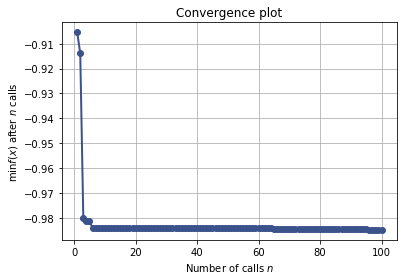

In [19]:
plot_convergence(search_result)

### Best Hyperparameters in the space

[Learning Rate, Number of Fully-Connected Layers, Number of Neurons in each Layer, Activation Function in each Layer, Patience]

In [20]:
search_result.x

[0.00037928335795705767, 2, 407, 'sigmoid', 14]

### Accuracy

In [21]:
-search_result.fun

0.9848

### Other Results

In [22]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.9848, [0.00037928335795705767, 2, 407, 'sigmoid', 14]),
 (-0.9846, [0.00012763943544590877, 1, 512, 'sigmoid', 25]),
 (-0.9846, [0.0003590110537208963, 2, 393, 'relu', 25]),
 (-0.9844, [0.0004951772874352258, 1, 512, 'sigmoid', 25]),
 (-0.984, [0.00021938182808403002, 2, 272, 'relu', 20]),
 (-0.9834, [0.00012688215171224396, 1, 433, 'relu', 8]),
 (-0.9828, [1.2393020308999365e-05, 5, 433, 'relu', 25]),
 (-0.9824, [0.0003444013577417812, 1, 512, 'relu', 25]),
 (-0.9822, [9.989453017108324e-05, 5, 319, 'relu', 25]),
 (-0.9816, [0.00012604415755507753, 2, 394, 'sigmoid', 24]),
 (-0.9812, [0.0007085468149471895, 2, 512, 'relu', 6]),
 (-0.9812, [0.0018140640575981706, 2, 378, 'relu', 12]),
 (-0.981, [5.669029434780921e-05, 2, 403, 'sigmoid', 25]),
 (-0.9808, [5.929755189453759e-05, 2, 512, 'relu', 25]),
 (-0.9804, [1.2332079197704047e-05, 1, 512, 'relu', 25]),
 (-0.9804, [0.00013703867939373845, 1, 164, 'sigmoid', 25]),
 (-0.9804, [0.0015097241299535937, 1, 474, 'relu', 1]),
 (-0.9804,